1. Get embeddings (resnet50)
2. knn ranking    (sklearn.neighbors.NearestNeighbors)


1. get embeddings   (resnet50)
2. classifier       (KNN)
3. knn within class (sklearn.neighbors.NearestNeighbors)


1. get embeddings           (resnet50)
2. Dimensionality reduction (PCA)
3. classifier               (KNN)
4. knn within class         (sklearn.neighbors.NearestNeighbors)


1. get embeddings           (AutoEncoder)
2. Dimensionality reduction (PCA)
3. classifier               (TripletLoss)
4. knn within class         (sklearn.neighbors.NearestNeighbors)


In [1]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

In [6]:
from imagesearch.utils import plot_confusion_matrix

In [7]:
# !python3 -m pip install seaborn
import seaborn as sn

In [8]:
image_folder = '/mnt/osn3/caceres/classes/geological/geological_similarity'

In [9]:
classes = [ 'andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

# Method 1: 
1. Get embeddings
2. knn ranking

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
from torchvision import transforms

In [11]:
resnet50 = models.resnet50(pretrained=False)

In [12]:
resnet50.load_state_dict(torch.load('/home/ccaceresgarcia/Documents/Projects/image_search/resnet50-19c8e357.pth')) # path of your weights

<All keys matched successfully>

In [13]:
_ = resnet50.eval()
_ = resnet50.cuda()

In [14]:
modules=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

In [15]:
transform = transforms.Compose([transforms.ToTensor()])

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

resnet50 = resnet50.to(device)


In [19]:

labels = []
filenames = []
features = []
for i, label in enumerate(classes):
    image_list = glob.glob(image_folder + '/' + label + '/*.jpg')

    for filename in image_list:

        image = Image.open(filename) # read image
        im = np.asarray(image)# convert image to numpy array
        img = transform(im) # convert to tensor
        #img = img.reshape(1,3,28,28)
        img = torch.unsqueeze(img, 0)
        img = img.to(device)

        with torch.no_grad():
            feature = resnet50(img)
        
        features.append(feature.cpu().detach().numpy().reshape(-1))
        labels.append(label)
        filenames.append(filename)
        
features2 = np.array(features)
print(features2.shape)

/home/ccaceresgarcia/miniconda3/envs/spot4/lib/python3.6/site-packages/torchvision/transforms/functional.py:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629416375/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


(29998, 2048)


# Perform pca

In [21]:
use_pca = True

In [22]:
if use_pca:
    import numpy as np
    from sklearn.decomposition import PCA

    pca = PCA(n_components=500)#'mle')
    pca.fit(features2) # n_samples, n_features

    print(pca.explained_variance_ratio_),print(pca.singular_values_)

    print(pca.singular_values_.shape)

    features3 = pca.transform(features2)


[1.83037668e-01 9.47057903e-02 6.37975931e-02 4.48456071e-02
 4.45953198e-02 3.57509926e-02 3.05183474e-02 2.59248465e-02
 2.01853272e-02 1.78568400e-02 1.62675940e-02 1.39877899e-02
 1.21153072e-02 1.13491239e-02 1.12042697e-02 9.74075217e-03
 9.30082798e-03 8.85589793e-03 8.07980634e-03 7.52337882e-03
 7.07510812e-03 6.58262894e-03 6.48492761e-03 6.11924985e-03
 5.98532846e-03 5.66486921e-03 5.48967533e-03 5.37240505e-03
 5.01135644e-03 4.77031665e-03 4.67192009e-03 4.59543476e-03
 4.27971268e-03 4.04507946e-03 3.90932523e-03 3.87820136e-03
 3.57431942e-03 3.56406788e-03 3.38408980e-03 3.35146929e-03
 3.17939324e-03 3.12713999e-03 3.07912123e-03 2.92324601e-03
 2.78267660e-03 2.73568043e-03 2.63194111e-03 2.52879760e-03
 2.51072086e-03 2.43246509e-03 2.36069504e-03 2.25152401e-03
 2.22581252e-03 2.16005254e-03 2.12886184e-03 2.02875445e-03
 1.99982780e-03 1.96520588e-03 1.91397325e-03 1.83544192e-03
 1.75102218e-03 1.73223042e-03 1.70816144e-03 1.69712130e-03
 1.68009347e-03 1.641165

In [38]:
pca.transform??

In [25]:
features2.shape, features3.shape

((29998, 2048), (29998, 500))

## Write vectors to file for s3 upload

In [ ]:
f3 = [str(list(x)) for x in features]

In [ ]:
import csv

with open("resnet_vectors.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(f3)

In [ ]:
label_features = {}
for i, label in enumerate(classes):
    label_features[i] = [(x, name) for name,x, la in zip(filenames, f3, labels) if la == label]

In [ ]:
[len(x) for i, x in label_features.items()]

### Per Class files

In [ ]:
for i, label in enumerate(classes):
    f4, lab_names = zip(*label_features[i])
    
    feature_data = {'labels':label, 
                'filenames':lab_names,
                'features':f4}
    
    with open('resnet_vectors_{}.json'.format(label), 'w') as f:
        json.dump(feature_data, f)

In [ ]:
feature_data = {'labels':labels, 
                'filenames':filenames,
                'features':f3}



In [ ]:
import json
with open('resnet_vectors.json', 'w') as f:
    json.dump(feature_data, f)

## Make KNN object

In [ ]:
# for i, label in enumerate(classes):
#     image_list = glob.glob(image_folder + '/' + label + '/*.jpg')
#     print(i,label, len(image_list))
    
# len(labels), len(filenames), len(features)

In [26]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=30, algorithm='brute',metric='euclidean').fit(features3)

In [ ]:
import pickle 

# Its important to use binary mode 
knnPickle = open('knnpickle_file', 'wb') 

# source, destination 
pickle.dump(neighbors, knnPickle)                      

# load the model from disk
loaded_model = pickle.load(open('knnpickle_file.pickle', 'rb'))


In [ ]:
with open('filenames.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(filenames, f, pickle.HIGHEST_PROTOCOL)

with open('filenames.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    loaded_filenames = pickle.load(f)

In [ ]:
# boto3
# !pip3 install requests_aws4auth
# !pip3 install elasticsearch=='7.13.4' #https://opensearch.org/docs/clients/index/


In [27]:
from io import BytesIO
import base64

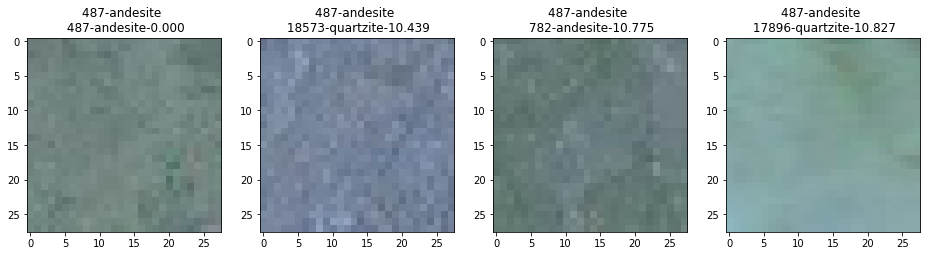

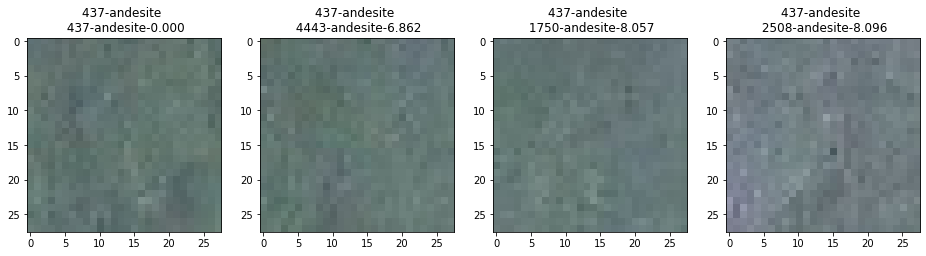

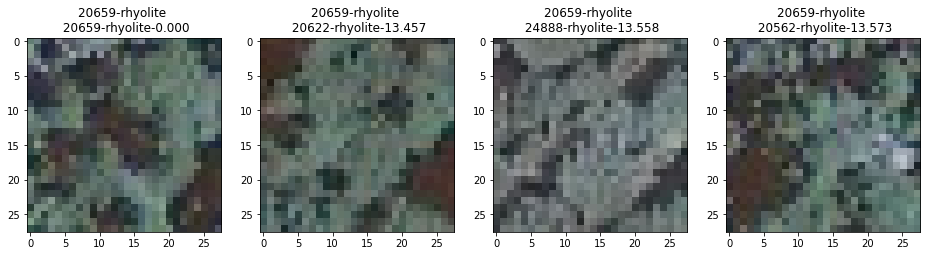

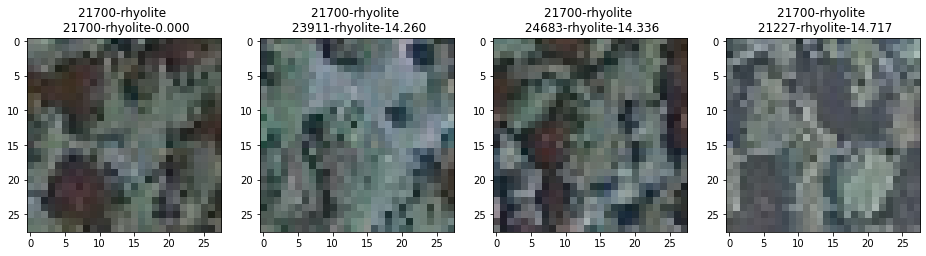

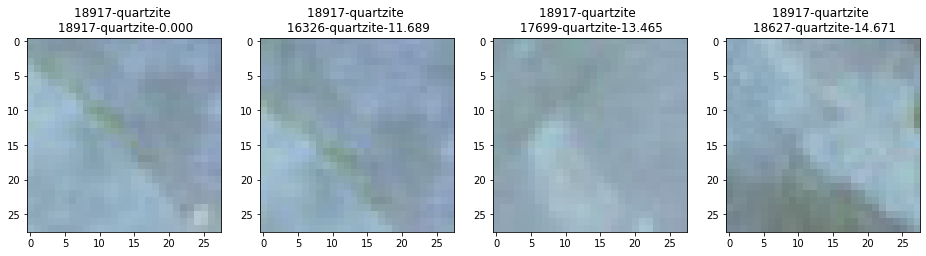

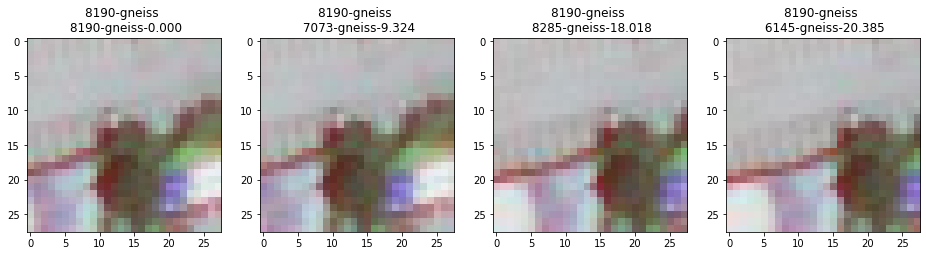

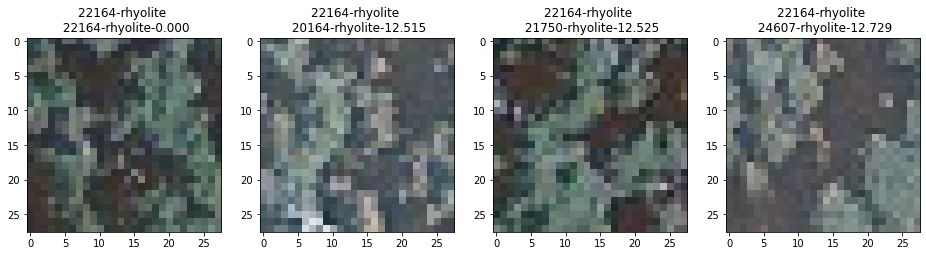

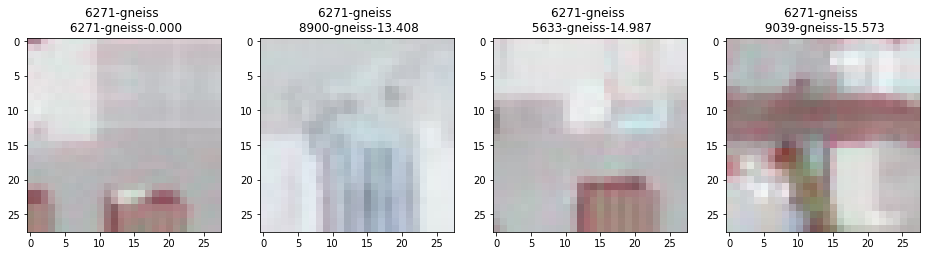

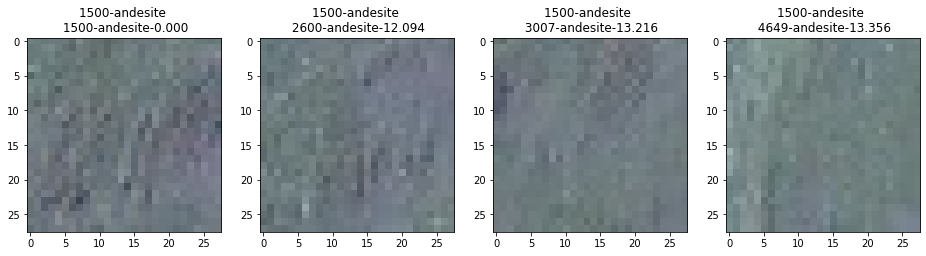

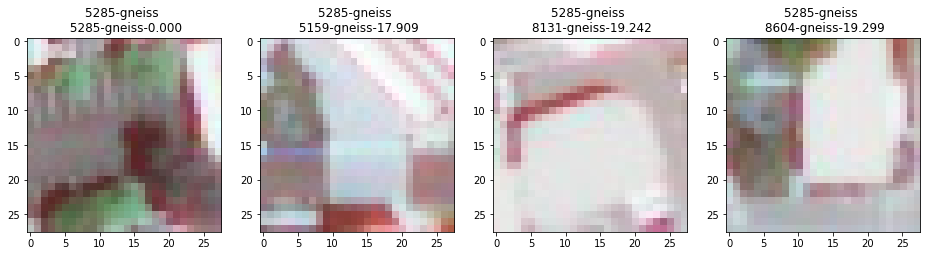

In [60]:
k = 4

for query in [random.randint(0,len(filenames)-1) for _ in range(10)]:
    
    
    image = Image.open(filenames[query]) # read image
    im = np.asarray(image)# convert image to numpy array
    img = transform(im) # convert to tensor
    img = torch.unsqueeze(img, 0)
    img = img.to(device)

    with torch.no_grad():
        feature = resnet50(img)

    flat_feature = feature.cpu().detach().numpy().reshape(-1)
    
    if use_pca:
        t = flat_feature[None,:] #.reshape(1, -1)
        #print(t.shape)
        flat_feature = pca.transform(t)
        #print(flat_feature.shape)
        
    distances, indices = neighbors.kneighbors(flat_feature)
    
    #distances, indices = neighbors.kneighbors([features2[query]])

    _, axes = plt.subplots(1,k,figsize=(16,4))
    for i in range(k):
        # load the image
        match = indices[0][i]
        image = Image.open(filenames[match])
        # convert image to numpy array
        im = np.asarray(image)
        axes.flat[i].imshow(im)
        axes.flat[i].set_title('{}-{} \n {}-{}-{:.3f}'.format(query, 
                                                              labels[query], 
                                                              match, 
                                                              labels[match], 
                                                              round(distances[0][i],3)))

In [61]:
import tqdm

In [62]:
def get_class(x):
    return os.path.split(os.path.split(x)[0])[1]

get_class(filenames[0])

'andesite'

In [68]:
def get_features(filename):
    image = Image.open(filename) # read image
    im = np.asarray(image)# convert image to numpy array
    img = transform(im) # convert to tensor
    img = torch.unsqueeze(img, 0)
    img = img.to(device)

    with torch.no_grad():
        feature = resnet50(img)

    flat_feature = feature.cpu().detach().numpy().reshape(-1)
    return flat_feature

def calculate_accuracy(model_func, filenames, k=5):
    correct = 0
    incorrect = 0
    for i in range(len(filenames)):

        flat_feature = model_func(filenames[i])

        if use_pca:
            t = flat_feature[None,:] #.reshape(1, -1)
            #print(t.shape)
            flat_feature = pca.transform(t)
            #print(flat_feature.shape)
        
        distances, indices = neighbors.kneighbors(flat_feature)
        #print(len(indices[0]))
        for j in range(k):
            if get_class(filenames[indices[0][j]]) == get_class(filenames[i]):
                correct += 1
            else:
                incorrect += 1
                
    return correct/(correct+incorrect)

In [69]:
import time

In [ ]:
for k in range(1,20):
    ts = time.time()
    acc = calculate_accuracy(get_features, filenames, k) 
    print(k, ':', acc, 'took: ', time.time() - ts)

# no pca
#5: 0.9083605573704914
# 10: 0.8805020334688979 took:  5141.556249380112

# 1 : 1.0 took:  5243.203317165375
# 2 : 0.9549969997999866 took:  5213.520396232605
# 3 : 0.9326510656265973 took:  5250.444738864899
# 4 : 0.9185779051936795 took:  5256.2421662807465
# 5 : 0.9083605573704914 took:  5201.220468044281
# 6 : 0.9006711558548348 took:  5276.318137168884
# 7 : 0.8940929395293019 took:  5241.118902921677

# pca 500

1 : 1.0 took:  1030.3831329345703


# Method 2:
1. get embeddings
2. classifier
3. knn within class

# Method 3:
1. get embeddings
2. dimensionality reduction
3. classifier
4. knn within class


In [ ]:
use_pca = False

## Get feature vectors

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
from torchvision import transforms

In [ ]:
resnet50 = models.resnet50(pretrained=False)

In [ ]:
resnet50.load_state_dict(torch.load('/home/ccaceresgarcia/Documents/Projects/image_search/resnet50-19c8e357.pth')) # path of your weights

In [ ]:
resnet50.eval()
resnet50.cuda()

In [ ]:
modules=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

In [ ]:

labels = []
filenames = []
features = {}
for i, label in enumerate(classes):
    image_list = glob.glob(image_folder + '/' + label + '/*.jpg')
    features[i] = []
    
    for filename in image_list:

        image = Image.open(filename) # read image
        im = np.asarray(image)# convert image to numpy array
        img = transform(im) # convert to tensor
        #img = img.reshape(1,3,28,28)
        img = torch.unsqueeze(img, 0)
        img = img.to(device)

        with torch.no_grad():
            feature = resnet50(img)
        
        flat_feature = feature.cpu().detach().numpy().reshape(-1)
        
        features[i].append((flat_feature, label, filename))

## Split into train/test

In [ ]:
test_perc = 0.2

train_set = []
test_set = []
for k,v in features.items():
    random.shuffle(v)
    test_count = int(test_perc * len(v))
    test_set.extend(v[:test_count])
    train_set.extend(v[test_count:])

In [ ]:
len(train_set), len(test_set)

In [ ]:
for k,v in features.items():
    print(k, len(v))

In [ ]:
train_features, train_labels, train_filenames = list(zip(*train_set))
test_features, test_labels, test_filenames = list(zip(*test_set))

In [ ]:
train_features = np.array(train_features)
test_features = np.array(test_features)

train_features.shape, test_features.shape

## PCA

In [ ]:
if use_pca:
    import numpy as np
    from sklearn.decomposition import PCA

    pca = PCA(n_components=500)#'mle')
    pca.fit(train_features) # n_samples, n_features

    print(pca.explained_variance_ratio_),print(pca.singular_values_)

    print(pca.singular_values_.shape)

    train_features = pca.transform(train_features)
    test_features = pca.transform(test_features)


In [ ]:
PCA?

In [ ]:
from sklearn.decomposition import PCA


## Train multiclass classifier

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(train_features)

# train_features = scaler.transform(train_features)
# test_features = scaler.transform(test_features)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_features, train_labels)

In [ ]:
y_pred = classifier.predict(test_features)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels, y_pred))

In [ ]:
plot_confusion_matrix(confusion_matrix(test_labels, y_pred), classes)

## Make nearest neighbors for each cluster

In [ ]:
from sklearn.neighbors import NearestNeighbors

k = 10
class_filenames = {}
class_labels = {}
neighbors = {}
for i, label in enumerate(classes):
    label_features = train_features[[x == label for x in train_labels]]
    
    neighbors[i] = NearestNeighbors(n_neighbors=k, algorithm='brute',metric='euclidean').fit(label_features)

    class_filenames[i] = list(np.array(train_filenames)[[x == label for x in train_labels]])
    class_labels[i] = list(np.array(train_labels)[[x == label for x in train_labels]])
    

# Query

In [ ]:
k=4
for query in [random.randint(0,len(test_filenames)-1) for _ in range(10)]:
    
    # get embedding
    image = Image.open(test_filenames[query]) # read image
    im = np.asarray(image)# convert image to numpy array
    img = transform(im) # convert to tensor
    img = torch.unsqueeze(img, 0)
    img = img.to(device)

    with torch.no_grad():
        feature = resnet50(img)

    flat_feature = feature.cpu().detach().numpy().reshape(-1)

    if use_pca:
        flat_feature = pca.transform([flat_feature])[0]

    # classify    
    y_pred = classifier.predict([flat_feature])
    
    best_class = [i for i,x in enumerate(classes) if x==y_pred[0]][0]
    print(query, test_labels[query], test_filenames[query], ' -- ', best_class, classes[best_class])
    
    # Do KNN ranking
    distances, indices = neighbors[best_class].kneighbors([test_features[query]])

    # display results
    _, axes = plt.subplots(1,k,figsize=(16,4))
    for i in range(k):
        # load the image
        match = indices[0][i]
        image = Image.open(class_filenames[best_class][match])
        # convert image to numpy array
        im = np.asarray(image)
        axes.flat[i].imshow(im)
        axes.flat[i].set_title('{}-{} \n {}-{}-{:.3f}'.format(query, 
                                                              test_labels[query], 
                                                              match, 
                                                              class_labels[best_class][match], 
                                                              distances[0][i]))


In [ ]:
len(test_filenames), len(train_filenames)

In [ ]:
def get_features(filename):
    image = Image.open(filename) # read image
    im = np.asarray(image)# convert image to numpy array
    img = transform(im) # convert to tensor
    img = torch.unsqueeze(img, 0)
    img = img.to(device)

    with torch.no_grad():
        feature = resnet50(img)

    flat_feature = feature.cpu().detach().numpy().reshape(-1)
    return flat_feature

def calculate_accuracy(model_func, filenames, class_filenames, k=5):
    correct = 0
    incorrect = 0
    try:
        for i in range(len(filenames)):

            flat_feature = model_func(filenames[i])

            if use_pca:
                flat_feature = pca.transform([flat_feature])[0]

            # classify    
            y_pred = classifier.predict([flat_feature])

            best_class = [i for i,x in enumerate(classes) if x==y_pred[0]][0]
            #print(filenames[i], classes[best_class])

            # Do KNN ranking
            distances, indices = neighbors[best_class].kneighbors([flat_feature])

            #print(len(indices[0]))
            for j in range(k):
                #print(class_filenames[best_class][indices[0][j]])
                #print(len(indices[0]))
                if get_class(class_filenames[best_class][indices[0][j]]) == get_class(filenames[i]):
                    correct += 1
                else:
                    incorrect += 1
                
            #print()
    except Exception as e:
        print(e)
        raise
                
    print(correct, incorrect)
    return correct/(correct+incorrect)



In [ ]:
for k in range(1,20):
    ts = time.time()
    acc = calculate_accuracy(get_features, test_filenames,class_filenames, k) 
    print(k, ':', acc, 'took: ', time.time() - ts)
    
    
# test, train: (5999, 23999)

# 1 : 0.16252708784797465 took:  484.7889847755432
# 2 : 0.163777296216036 took:  499.36162662506104
# 3 : 0.16802800466744458 took:  537.5407359600067
# 4 : 0.16840306717786296 took:  699.1935892105103
# 5 : 0.16816136022670444 took:  700.9886512756348

# 1 : 0.16252708784797465 took:  686.6163864135742
# 2 : 0.163777296216036 took:  688.2843124866486
# 3 : 0.16802800466744458 took:  661.0861706733704
# 4 : 0.16840306717786296 took:  585.4335458278656
# 5 : 0.16816136022670444 took:  481.48185420036316
# 6 : 0.1666111018503084 took:  481.5280101299286
# 7 : 0.1668135165384707 took:  487.74747705459595
# 8 : 0.16746541090181696 took:  471.3130807876587
# 9 : 0.16684262191846788 took:  481.1854131221771
# 10 : 0.16676112685447575 took:  480.85516905784607

In [ ]:
#                 print(class_filenames[best_class][indices[0][j]])

class_filenames[0][[[3639, 2375, 2701, 2485, 1909, 3002, 1942,  804, 3119, 3004]][0][0]]

In [ ]:
476.6880519390106
11032 966
2 : 0.9194865810968494 took:  